# 1. Цель лабораторной работы

Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей

# 2. Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8. Постройте кривые обучения и валидации.

# 3. Ход выполнения работы

In [0]:
from google.colab import files

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [29]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

## Предварительная подготовка данных

Датасет - Suicide Rates Overview 1985 to 2016. This compiled dataset pulled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum.

In [0]:
data = pd.read_csv("Measurement_summary.csv", delimiter=',')

Верхушка данных и типы

In [56]:
data.head(5)

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


In [57]:
data.dtypes

Measurement date     object
Station code          int64
Address              object
Latitude            float64
Longitude           float64
SO2                 float64
NO2                 float64
O3                  float64
CO                  float64
PM10                float64
PM2.5               float64
dtype: object

In [58]:
data.isnull().sum()

Measurement date    0
Station code        0
Address             0
Latitude            0
Longitude           0
SO2                 0
NO2                 0
O3                  0
CO                  0
PM10                0
PM2.5               0
dtype: int64

Уберем столбец с названиями и преобразуем дату в соответствующий временной формат:

In [0]:
df = data.copy()

df["Measurement date"] = pd.to_datetime(df["Measurement date"]).astype(np.int64)/1000000

df = df.drop(["Address"], axis=1)

'''
df["Region_ID"] =df["Region_ID"].fillna(method='ffill')
'''

df=df.dropna()

In [60]:
df.head(5)

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,1.483229e+12,101,37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,1.483232e+12,101,37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,1.483236e+12,101,37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,1.483240e+12,101,37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,1.483243e+12,101,37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


In [61]:
df.dtypes

Measurement date    float64
Station code          int64
Latitude            float64
Longitude           float64
SO2                 float64
NO2                 float64
O3                  float64
CO                  float64
PM10                float64
PM2.5               float64
dtype: object

Проверим размер набора данных:

In [62]:
df.shape

(19297, 10)

Проверим основные статистические характеристики набора данных:

In [63]:
df.describe()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,1.929700e+04,19297.0,1.929700e+04,1.929700e+04,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000
mean,1.517969e+12,101.0,3.757202e+01,1.270050e+02,0.003144,0.031642,0.023252,0.599591,39.894025,23.888014
std,2.006735e+10,0.0,1.077211e-11,9.237295e-12,0.038573,0.042900,0.043680,0.528948,27.922486,20.021437
min,1.483229e+12,101.0,3.757202e+01,1.270050e+02,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.500595e+12,101.0,3.757202e+01,1.270050e+02,0.003000,0.019000,0.009000,0.400000,22.000000,12.000000
50%,1.517962e+12,101.0,3.757202e+01,1.270050e+02,0.004000,0.030000,0.022000,0.500000,34.000000,19.000000
75%,1.535328e+12,101.0,3.757202e+01,1.270050e+02,0.005000,0.044000,0.035000,0.700000,50.000000,30.000000
max,1.553497e+12,101.0,3.757202e+01,1.270050e+02,0.406000,0.109000,0.325000,40.000000,479.000000,437.000000


## Разделение данных

Разделим данные на целевой столбец и признаки:

In [0]:
X = df.drop("PM10", axis=1)
y = df["PM10"]

In [65]:
print(X.head(), "\n")
print(y.unique()[1:20])

   Measurement date  Station code   Latitude  ...     O3   CO  PM2.5
0      1.483229e+12           101  37.572016  ...  0.002  1.2   57.0
1      1.483232e+12           101  37.572016  ...  0.002  1.2   59.0
2      1.483236e+12           101  37.572016  ...  0.002  1.2   59.0
3      1.483240e+12           101  37.572016  ...  0.002  1.2   58.0
4      1.483243e+12           101  37.572016  ...  0.002  1.2   61.0

[5 rows x 9 columns] 

[ 71.  70.  69.  66.  72.  74.  76.  83.  93.  94.  87.  91.  92.  89.
  90.  88.  85.  80. 104.]


In [66]:
print(X.shape)
print(y.shape)

(19297, 9)
(19297,)


Предобработка

In [67]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM2.5
count,1.929700e+04,19297.0,19297.0,19297.0,1.929700e+04,1.929700e+04,1.929700e+04,1.929700e+04,1.929700e+04
mean,4.769811e-15,0.0,0.0,1.0,1.479319e-15,-4.592349e-16,1.163621e-15,-2.303205e-15,-1.254828e-15
std,1.000026e+00,0.0,0.0,0.0,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-1.731225e+00,0.0,0.0,1.0,-2.600706e+01,-2.404818e+01,-2.342668e+01,-3.024177e+00,-1.243100e+00
25%,-8.657972e-01,0.0,0.0,1.0,-3.744338e-03,-2.946976e-01,-3.262810e-01,-3.773449e-01,-5.937796e-01
50%,-3.689439e-04,0.0,0.0,1.0,2.218121e-02,-3.828120e-02,-2.865443e-02,-1.882855e-01,-2.441453e-01
75%,8.650593e-01,0.0,0.0,1.0,4.810675e-02,2.880670e-01,2.689722e-01,1.898335e-01,3.052800e-01
max,1.770494e+00,0.0,0.0,1.0,1.044425e+01,1.803255e+00,6.908335e+00,7.449020e+01,2.063402e+01


Разделение на тренировочную/тестовую выборку

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=1478264)

In [69]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14472, 9)
(4825, 9)
(14472,)
(4825,)


## Модель ближайших соседей для произвольно заданного гиперпараметра K

Функция, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

Метод ближайших соседей с гиперпараметром K=8:

In [71]:
reg_8 = KNeighborsRegressor(n_neighbors=8)
reg_8.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

Метрики построенной модели:

In [72]:
test_model(reg_8)

mean_absolute_error: 6.30020725388601
median_absolute_error: 3.625
r2_score: 0.8104550565067937


В данном случае модель более-менее состоятельна.

## Использование кросс-валидации

Классический K-fold:

In [73]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=8), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.7066427  0.24899834 0.42595807 0.64070441 0.7600831  0.63183593
 0.74235987 0.77394996 0.53745256 0.8085329 ]
0.6276517844658902 ± 0.16835654340363854


In [74]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=8), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.81152566 0.82878025 0.80949061 0.76721385 0.79209436 0.78143027
 0.78849556 0.83075587 0.8010343  0.81905352]
0.8029874250605994 ± 0.01971450078909764


In [75]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=8), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.84492557 0.80921773 0.79642315 0.80782787 0.7984946  0.83568169
 0.82420205 0.83395701 0.851709   0.83512926]
0.8237567924938747 ± 0.018589359754584655


## Подбор гиперпараметра K

Генерация массива разных значений K

In [76]:
n_range = np.array(range(1, 50, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

Подбор параметра:

In [77]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 5}

Результаты при разных значения гиперпараметра на тренировочном наборе данных:

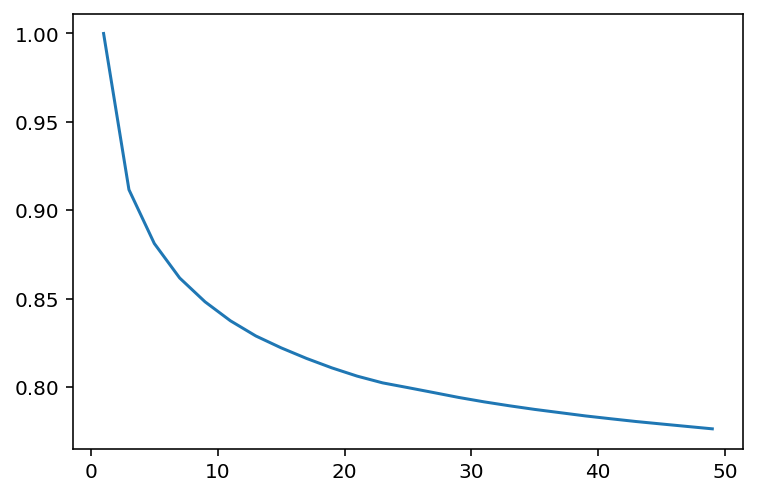

In [78]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

Очевидно, что для K=1 на тренировочном наборе данных мы находим ровно ту же точку, что и нужно предсказать, и чем больше её соседей мы берём — тем меньше точность.

На тестовом наборе:

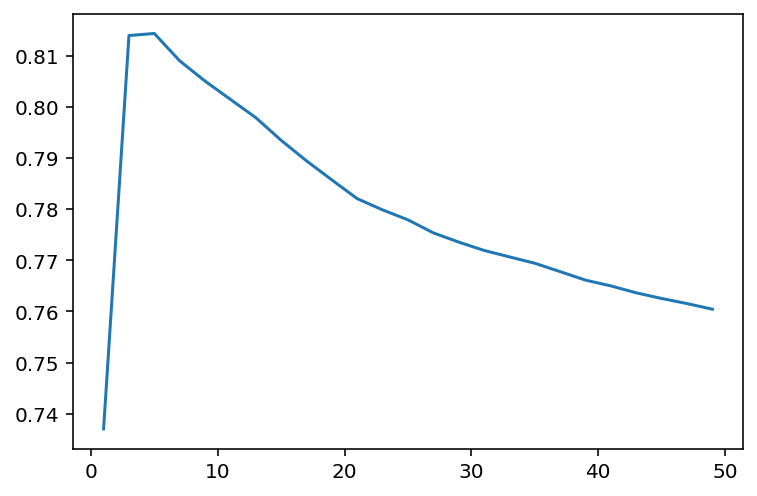

In [79]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

Сначала увеличение количества соседей увеличивает точность, однако она довольно быстро достигает пика и начинает уменьшаться при дальнейшем увеличении параметра.

Проверим получившуюся модель:

In [80]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 6.189139896373057
median_absolute_error: 3.4000000000000057
r2_score: 0.8254950841205269


Построим кривую обучения:

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    train_sizes=np.linspace(.1, 1.0, 5)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

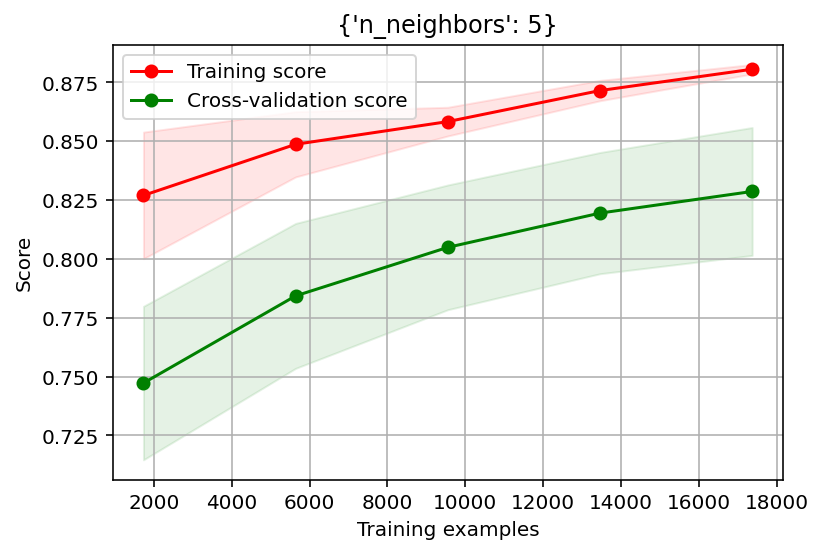

In [82]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
                    cv=ShuffleSplit(n_splits=10));

Построим кривую валидации:

In [0]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
                 label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

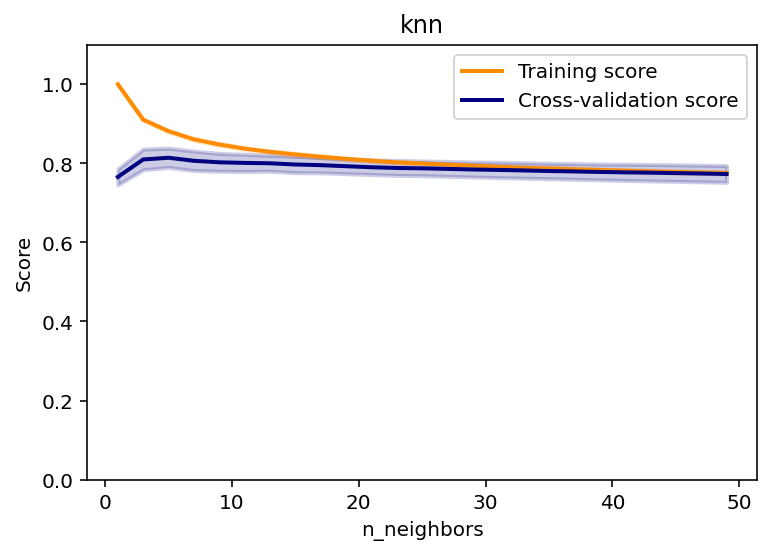

In [84]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y, 
                      param_name="n_neighbors", param_range=n_range, 
                      cv=ShuffleSplit(n_splits=10), scoring="r2");